# Comparison of neural Models
This notebook creates a comparison of how our neural models perform. We will try each model with and without word embeddings, and produce visualisations of model performance. 

# Feed-Forward Neural Networks
First we will find this difference for Feed-Forward Neural Networks (FFNN):

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Embedding, Flatten, LSTM, MaxPooling2D
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import text_to_word_sequence, Tokenizer
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from scripts import training_helpers
from sklearn.model_selection import train_test_split, StratifiedKFold

from gensim.models import KeyedVectors
from seaborn import boxplot
from pandas import DataFrame

We will cross validate our model, so lets create a function to handle this for us. It will use StratifiedKFold splitting:

In [2]:
def run_cross_validate(get_model, X, y, cv=5, categorical=False, add_target_dim=False):
  skfSplitter = StratifiedKFold(n_splits=cv, shuffle=True)
  metrics = {
    "accuracies": [],
  }
    
  for train_indices, test_indices in skfSplitter.split(X, y):
    training_X = np.array([X[x] for x in train_indices])
    training_y = np.array([y[x] for x in train_indices])
    test_X = np.array([X[x] for x in test_indices])
    test_y = np.array([y[x] for x in test_indices])
    
    if categorical:
      training_y = to_categorical(training_y)
      test_y = to_categorical(test_y)
    if add_target_dim:
      training_y = np.array([[y] for y in training_y])
      test_y = np.array([[y] for y in test_y])
    
    model = get_model()
    print("Fitting with: ", np.array(training_X).shape, "labels", np.array(training_y).shape)
    model.fit(np.array(training_X), training_y, epochs=12, batch_size=16, validation_split=0.3,
              callbacks=[EarlyStopping(monitor='val_loss', patience=4)])
    metrics["accuracies"].append(model.evaluate(np.array(test_X), test_y)[1])
  return metrics

First we find results for our Bag of Words (BoW) model:

In [3]:
data_frame = training_helpers.get_data_frame()

predictors_raw = data_frame['review']
num_words = 20000

tokenizer = Tokenizer(num_words)
tokenizer.fit_on_texts(predictors_raw)
bow_predictors = tokenizer.texts_to_matrix(predictors_raw, mode='tfidf')
labels = [x for x in data_frame['deceptive']]

In [4]:
def get_ff_bow_model():
  model = Sequential([
      Dense(16, activation=relu, input_shape=(num_words,), kernel_regularizer=l2(0.01)),
      Dropout(0.25),
      Dense(8, activation=relu, kernel_regularizer=l2(0.01)),
      Dense(1, activation=sigmoid)
  ])
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model

ff_bow_scores = run_cross_validate(get_ff_bow_model, bow_predictors, labels, cv=10)

Fitting with:  (1440, 20000) labels (1440,)
Train on 1007 samples, validate on 433 samples
Epoch 1/12
1007/1007 [==============================] - 2s 2ms/step - loss: 0.6841 - acc: 0.7299 - val_loss: 0.4919 - val_acc: 0.8753
Epoch 2/12
1007/1007 [==============================] - 1s 979us/step - loss: 0.3207 - acc: 0.9533 - val_loss: 0.4375 - val_acc: 0.8845
Epoch 3/12
1007/1007 [==============================] - 1s 954us/step - loss: 0.2247 - acc: 0.9861 - val_loss: 0.4551 - val_acc: 0.8684
Epoch 4/12
1007/1007 [==============================] - 1s 846us/step - loss: 0.1878 - acc: 0.9921 - val_loss: 0.4220 - val_acc: 0.8799
Epoch 5/12
1007/1007 [==============================] - 1s 996us/step - loss: 0.1701 - acc: 0.9921 - val_loss: 0.4326 - val_acc: 0.8845
Epoch 6/12
1007/1007 [==============================] - 1s 1ms/step - loss: 0.1619 - acc: 0.9960 - val_loss: 0.4388 - val_acc: 0.8707
Epoch 7/12
1007/1007 [==============================] - 1s 942us/step - loss: 0.1410 - acc: 0.997

Train on 1007 samples, validate on 433 samples
Epoch 1/12
1007/1007 [==============================] - 2s 2ms/step - loss: 0.7634 - acc: 0.6634 - val_loss: 0.5894 - val_acc: 0.8822
Epoch 2/12
1007/1007 [==============================] - 1s 1ms/step - loss: 0.4324 - acc: 0.9166 - val_loss: 0.4643 - val_acc: 0.8938
Epoch 3/12
1007/1007 [==============================] - 1s 1ms/step - loss: 0.2883 - acc: 0.9742 - val_loss: 0.4305 - val_acc: 0.8776
Epoch 4/12
1007/1007 [==============================] - 1s 1ms/step - loss: 0.2227 - acc: 0.9841 - val_loss: 0.4194 - val_acc: 0.8938
Epoch 5/12
1007/1007 [==============================] - 1s 1ms/step - loss: 0.1930 - acc: 0.9911 - val_loss: 0.4176 - val_acc: 0.8799
Epoch 6/12
1007/1007 [==============================] - 1s 1ms/step - loss: 0.1785 - acc: 0.9911 - val_loss: 0.4234 - val_acc: 0.8707
Epoch 7/12
1007/1007 [==============================] - 1s 1ms/step - loss: 0.1646 - acc: 0.9940 - val_loss: 0.4333 - val_acc: 0.8822
Epoch 8/12
1007

And for our word vector method. First we must create our word vectors using a word vectorizing model generated in another experiment:

In [8]:
word_vectors = KeyedVectors.load("opspam_w2v.kv", mmap="r")

predictors_sequences = pad_sequences(tokenizer.texts_to_sequences(predictors_raw))
max_sequence_length = max([len(x) for x in predictors_sequences])

In [9]:
embedding_length = word_vectors.vector_size

corpus_words = tokenizer.word_index
corpus_vocab_size = len(corpus_words)+1
vectorizer_words = word_vectors.wv
embedding_matrix = np.zeros((corpus_vocab_size, embedding_length))
for word, idx in corpus_words.items():
  if word in vectorizer_words.vocab:
    embedding_matrix[idx] = np.array(vectorizer_words[word], dtype=np.float32)

In [7]:
def get_ff_wv_model():
  model_ff_wv = Sequential([
      Embedding(corpus_vocab_size, embedding_length, weights=[embedding_matrix], trainable=False,
                input_length=max_sequence_length),
      Flatten(),
      Dense(16, activation=relu, kernel_regularizer=l2(0.01)), #, input_shape=(num_words,)
      Dropout(0.25),
      Dense(8, activation=relu, kernel_regularizer=l2(0.01)),
      Dense(1, activation=sigmoid)
  ])
  model_ff_wv.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model_ff_wv

ff_wv_scores = run_cross_validate(get_ff_wv_model, predictors_sequences, labels, cv=10)

Fitting with:  (1440, 784) labels (1440,)
Train on 1007 samples, validate on 433 samples
Epoch 1/12
1007/1007 [==============================] - 3s 3ms/step - loss: 0.9209 - acc: 0.4826 - val_loss: 0.8241 - val_acc: 0.5058
Epoch 2/12
1007/1007 [==============================] - 2s 2ms/step - loss: 0.7935 - acc: 0.5283 - val_loss: 0.7679 - val_acc: 0.5820
Epoch 3/12
1007/1007 [==============================] - 2s 2ms/step - loss: 0.7564 - acc: 0.5591 - val_loss: 0.7637 - val_acc: 0.5912
Epoch 4/12
1007/1007 [==============================] - 2s 2ms/step - loss: 0.7345 - acc: 0.5809 - val_loss: 0.7491 - val_acc: 0.5843
Epoch 5/12
1007/1007 [==============================] - 2s 2ms/step - loss: 0.7040 - acc: 0.6207 - val_loss: 0.7282 - val_acc: 0.5543
Epoch 6/12
1007/1007 [==============================] - 2s 2ms/step - loss: 0.6990 - acc: 0.6246 - val_loss: 0.7280 - val_acc: 0.6143
Epoch 7/12
1007/1007 [==============================] - 2s 2ms/step - loss: 0.6904 - acc: 0.6157 - val_loss

Epoch 9/12
1007/1007 [==============================] - 2s 2ms/step - loss: 0.6993 - acc: 0.6127 - val_loss: 0.7485 - val_acc: 0.5150
Epoch 10/12
1007/1007 [==============================] - 2s 2ms/step - loss: 0.7053 - acc: 0.6117 - val_loss: 0.7538 - val_acc: 0.5866
Epoch 11/12
160/160 [==============================] - 0s 492us/step
Fitting with:  (1440, 784) labels (1440,)
Train on 1007 samples, validate on 433 samples
Epoch 1/12
1007/1007 [==============================] - 5s 5ms/step - loss: 0.8920 - acc: 0.5055 - val_loss: 0.8175 - val_acc: 0.4873
Epoch 2/12
1007/1007 [==============================] - 2s 2ms/step - loss: 0.7954 - acc: 0.5154 - val_loss: 0.7949 - val_acc: 0.5242
Epoch 3/12
1007/1007 [==============================] - 2s 2ms/step - loss: 0.7746 - acc: 0.5174 - val_loss: 0.7670 - val_acc: 0.5035
Epoch 4/12
1007/1007 [==============================] - 2s 2ms/step - loss: 0.7491 - acc: 0.5283 - val_loss: 0.7389 - val_acc: 0.5473
Epoch 5/12
1007/1007 [===============

In [8]:
print ("Bag of words: ", ff_bow_scores['accuracies'])
print ("Word vectors: ", ff_wv_scores['accuracies'])

ff_scores_entries =[('Bag of Words', x) for x in ff_bow_scores['accuracies']] + [('Word Vectors', x) for x in ff_wv_scores['accuracies']]
ff_scores_data_frame = DataFrame(ff_scores_entries, columns=['input type', 'accuracy'])

Bag of words:  [0.875, 0.85625, 0.88125, 0.8875, 0.84375, 0.89375, 0.91875, 0.8375, 0.86875, 0.86875]
Word vectors:  [0.625, 0.63125, 0.54375, 0.50625, 0.5625, 0.5875, 0.5625, 0.625, 0.54375, 0.55625]


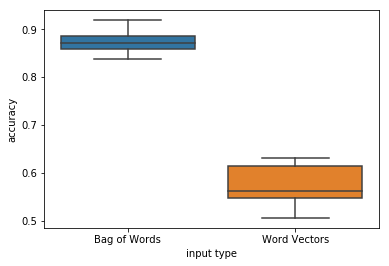

In [9]:
boxplot(x='input type', y='accuracy', data=ff_scores_data_frame)
plt.show()

The results are very strange! How could word vectors be less accurate than bag of words? This is known to occur when two conditions are met:
    
* The dataset is small
* The dataset is very domain specific

It is possible that these conditions actually are met here. The problem however is that running these models over our full dataset will take much longer, and will require a commited experiment to complete the investigation.

# Convolutional Network
Now let's try this with a convolutional network. It has been shown that word vectors perform better for text classification than Bag of Words. If BoW is more accurate, it is a clear sign that we should investigate why. First we find the Bag of Words result:

In [4]:
bow_predictors.shape

(1600, 20000)

In [5]:
batches = 1600
convolutional_data = np.array(np.split(np.array([[[y] for y in z] for z in bow_predictors]), batches))
convolutional_data.shape

(1600, 1, 20000, 1)

In [6]:
def get_conv_bow_model():
  model = Sequential([
      Conv2D(
          filters=50,
          kernel_size=(1, 10),
          data_format="channels_last",
          input_shape=(1, 20000, 1),
          activation=relu),
      MaxPooling2D(pool_size=(1, 10)),
      Dropout(0.2),
      Flatten(),
      Dense(2, activation='softmax')
  ])
  model.compile(
      loss='binary_crossentropy',
      optimizer='adam',
      metrics=['accuracy'])
  return model

In [7]:
conv_bow_scores = run_cross_validate(get_conv_bow_model, convolutional_data, labels, cv=10, categorical=True)

Fitting with:  (1440, 1, 20000, 1) labels (1440, 2)
Train on 1007 samples, validate on 433 samples
Epoch 1/12
1007/1007 [==============================] - 16s 16ms/step - loss: 0.4104 - acc: 0.8133 - val_loss: 0.6877 - val_acc: 0.6420
Epoch 2/12
1007/1007 [==============================] - 16s 16ms/step - loss: 0.1270 - acc: 0.9563 - val_loss: 0.7839 - val_acc: 0.6305
Epoch 3/12
1007/1007 [==============================] - 16s 16ms/step - loss: 0.0611 - acc: 0.9891 - val_loss: 0.9292 - val_acc: 0.6120
Epoch 4/12
1007/1007 [==============================] - 15s 15ms/step - loss: 0.0412 - acc: 0.9911 - val_loss: 1.1034 - val_acc: 0.5889
Epoch 5/12
160/160 [==============================] - 1s 7ms/step
Fitting with:  (1440, 1, 20000, 1) labels (1440, 2)
Train on 1007 samples, validate on 433 samples
Epoch 1/12
1007/1007 [==============================] - 16s 15ms/step - loss: 0.4176 - acc: 0.8064 - val_loss: 0.7610 - val_acc: 0.6189
Epoch 2/12
1007/1007 [==============================] - 

And our word vector result:

In [11]:
def vectorize_review(review_words):
  sentence = []
  for word in review_words:
    if word in word_vectors.wv:
      sentence.append(word_vectors.wv['dog'])
  return np.array(sentence, np.float64)

In [12]:
def pad_vectorized_review(vectorized_review, length):
  return np.concatenate((vectorized_review, np.zeros((length - len(vectorized_review), 100))))

In [13]:
vectorized_reviews = [vectorize_review(text_to_word_sequence(x)) for x in predictors_raw]
pad_length = max([x.shape[0] for x in vectorized_reviews])
vectorized_reviews = np.array([[pad_vectorized_review(x, pad_length)] for x in vectorized_reviews])

In [14]:
print(vectorized_reviews.shape)

(1600, 1, 381, 100)


In [15]:
def get_conv_wv_model():
  model = Sequential([
      Conv2D(
          filters=50,
          kernel_size=(10, 100),
          data_format="channels_first",
          input_shape=(1, 381, 100),
          activation=relu),
      MaxPooling2D(strides=(1, 1), pool_size=(2, 1), data_format="channels_first"),
      Dropout(0.2),
      Flatten(),
      Dense(2, activation='softmax')
  ])
  model.compile(
      loss='binary_crossentropy',
      optimizer='adam',
      metrics=['accuracy'])
  return model

In [16]:
conv_wv_scores = run_cross_validate(get_conv_wv_model, vectorized_reviews, labels, cv=6, categorical=True)

Fitting with:  (1332, 1, 381, 100) labels (1332, 2)
Train on 932 samples, validate on 400 samples
Epoch 1/12
932/932 [==============================] - 6s 7ms/step - loss: 0.6975 - acc: 0.4764 - val_loss: 0.6934 - val_acc: 0.4475
Epoch 2/12
932/932 [==============================] - 5s 5ms/step - loss: 0.6915 - acc: 0.5300 - val_loss: 0.6942 - val_acc: 0.5025
Epoch 3/12
932/932 [==============================] - 4s 5ms/step - loss: 0.6849 - acc: 0.5590 - val_loss: 0.6958 - val_acc: 0.4925
Epoch 4/12
932/932 [==============================] - 4s 5ms/step - loss: 0.6753 - acc: 0.5869 - val_loss: 0.7030 - val_acc: 0.5225
Epoch 5/12
268/268 [==============================] - 1s 2ms/step
Fitting with:  (1332, 1, 381, 100) labels (1332, 2)
Train on 932 samples, validate on 400 samples
Epoch 1/12
932/932 [==============================] - 6s 7ms/step - loss: 0.6989 - acc: 0.4775 - val_loss: 0.6931 - val_acc: 0.4975
Epoch 2/12
932/932 [==============================] - 5s 5ms/step - loss: 0.69

In [17]:
print ("Bag of words: ", conv_bow_scores['accuracies'])
print ("Word vectors: ", conv_wv_scores['accuracies'])

conv_scores_entries =[('Bag of Words', x) for x in conv_bow_scores['accuracies']] + [('Word Vectors', x) for x in conv_wv_scores['accuracies']]
conv_scores_data_frame = DataFrame(conv_scores_entries, columns=['input type', 'accuracy'])

Bag of words:  [0.84375, 0.86875, 0.7625, 0.825, 0.86875, 0.85, 0.8, 0.8375, 0.8375, 0.78125]
Word vectors:  [0.4738805965701146, 0.5, 0.488721804063123, 0.5300751881940025, 0.4812030079669522, 0.496240601727837]


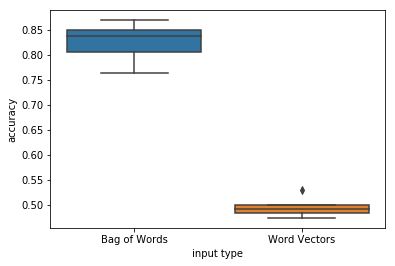

In [19]:
boxplot(x='input type', y='accuracy', data=conv_scores_data_frame)
plt.show()

Just as before our results are alarming. We need to investigate why this can occur, it may be that we have made a mistake in generating our word vectors

# Recurrent Neural Networks
Let's also try this same experiment for Recurrent Neural Networks. We will use LSTM since this is known to be a good option for text classification. First with Bag of Words:

In [4]:
batches = 1600
rnn_bow_data = np.array(np.split(bow_predictors, batches))
rnn_bow_data.shape

(1600, 1, 20000)

In [5]:
rnn_bow_targets = np.array([[x] for x in labels])
rnn_bow_targets.shape

(1600, 1)

In [6]:
def get_rnn_bow_model():
  model = Sequential([
      LSTM(8, input_shape=(1, 20000)),
      Dense(1, activation='sigmoid')
  ])
  model.compile(
      loss='binary_crossentropy',
      optimizer='adam',
      metrics=['accuracy'])
  return model

rnn_bow_scores = run_cross_validate(get_rnn_bow_model, rnn_bow_data, rnn_bow_targets, cv=10)

Fitting with:  (1440, 1, 20000) labels (1440, 1)
Train on 1007 samples, validate on 433 samples
Epoch 1/12
1007/1007 [==============================] - 3s 3ms/step - loss: 0.5428 - acc: 0.7637 - val_loss: 0.3637 - val_acc: 0.8799
Epoch 2/12
1007/1007 [==============================] - 1s 1ms/step - loss: 0.1343 - acc: 0.9861 - val_loss: 0.3267 - val_acc: 0.8753
Epoch 3/12
1007/1007 [==============================] - 1s 1ms/step - loss: 0.0618 - acc: 0.9990 - val_loss: 0.3146 - val_acc: 0.8891
Epoch 4/12
1007/1007 [==============================] - 1s 1ms/step - loss: 0.0396 - acc: 1.0000 - val_loss: 0.3132 - val_acc: 0.8915
Epoch 5/12
1007/1007 [==============================] - 1s 1ms/step - loss: 0.0288 - acc: 1.0000 - val_loss: 0.3127 - val_acc: 0.8868
Epoch 6/12
1007/1007 [==============================] - 1s 1ms/step - loss: 0.0224 - acc: 1.0000 - val_loss: 0.3150 - val_acc: 0.8868
Epoch 7/12
1007/1007 [==============================] - 1s 1ms/step - loss: 0.0180 - acc: 1.0000 - v

1007/1007 [==============================] - 1s 1ms/step - loss: 0.0615 - acc: 0.9990 - val_loss: 0.2955 - val_acc: 0.8915
Epoch 5/12
1007/1007 [==============================] - 1s 1ms/step - loss: 0.0450 - acc: 1.0000 - val_loss: 0.2853 - val_acc: 0.8961
Epoch 6/12
1007/1007 [==============================] - 1s 1ms/step - loss: 0.0350 - acc: 1.0000 - val_loss: 0.2822 - val_acc: 0.8984
Epoch 7/12
1007/1007 [==============================] - 1s 1ms/step - loss: 0.0282 - acc: 1.0000 - val_loss: 0.2824 - val_acc: 0.8961
Epoch 8/12
1007/1007 [==============================] - 1s 1ms/step - loss: 0.0234 - acc: 1.0000 - val_loss: 0.2832 - val_acc: 0.8961
Epoch 9/12
1007/1007 [==============================] - 1s 1ms/step - loss: 0.0198 - acc: 1.0000 - val_loss: 0.2830 - val_acc: 0.8984
Epoch 10/12
160/160 [==============================] - 0s 230us/step
Fitting with:  (1440, 1, 20000) labels (1440, 1)
Train on 1007 samples, validate on 433 samples
Epoch 1/12
1007/1007 [====================

And with Word Vectors:

In [10]:
def get_rnn_wv_model():
  model = Sequential([
      Embedding(corpus_vocab_size, embedding_length, weights=[embedding_matrix], input_length=max_sequence_length,
                trainable=False),
      LSTM(8),
      Dense(1, activation='sigmoid')
  ])
  model.compile(
      loss='binary_crossentropy',
      optimizer='adam',
      metrics=['accuracy'])
  return model

rnn_wv_scores = run_cross_validate(get_rnn_wv_model, predictors_sequences, labels, cv=10)

Fitting with:  (1440, 784) labels (1440,)
Train on 1007 samples, validate on 433 samples
Epoch 1/12
1007/1007 [==============================] - 62s 62ms/step - loss: 0.6888 - acc: 0.5402 - val_loss: 0.6834 - val_acc: 0.5404
Epoch 2/12
1007/1007 [==============================] - 57s 57ms/step - loss: 0.6733 - acc: 0.5909 - val_loss: 0.6546 - val_acc: 0.6236
Epoch 3/12
1007/1007 [==============================] - 56s 56ms/step - loss: 0.6554 - acc: 0.6038 - val_loss: 0.6469 - val_acc: 0.6189
Epoch 4/12
1007/1007 [==============================] - 60s 59ms/step - loss: 0.6487 - acc: 0.6187 - val_loss: 0.6443 - val_acc: 0.6259
Epoch 5/12
1007/1007 [==============================] - 58s 58ms/step - loss: 0.6480 - acc: 0.6137 - val_loss: 0.6396 - val_acc: 0.6351
Epoch 6/12
1007/1007 [==============================] - 61s 60ms/step - loss: 0.6374 - acc: 0.6266 - val_loss: 0.6375 - val_acc: 0.6397
Epoch 7/12
1007/1007 [==============================] - 62s 62ms/step - loss: 0.6345 - acc: 0.6

1007/1007 [==============================] - 65s 64ms/step - loss: 0.6331 - acc: 0.6485 - val_loss: 0.6256 - val_acc: 0.6582
Epoch 9/12
1007/1007 [==============================] - 65s 64ms/step - loss: 0.6318 - acc: 0.6435 - val_loss: 0.6302 - val_acc: 0.6282
Epoch 10/12
1007/1007 [==============================] - 66s 65ms/step - loss: 0.6230 - acc: 0.6455 - val_loss: 0.6141 - val_acc: 0.6697
Epoch 11/12
1007/1007 [==============================] - 64s 64ms/step - loss: 0.6309 - acc: 0.6475 - val_loss: 0.6288 - val_acc: 0.6374
Epoch 12/12
160/160 [==============================] - 0s 3ms/step
Fitting with:  (1440, 784) labels (1440,)
Train on 1007 samples, validate on 433 samples
Epoch 1/12
1007/1007 [==============================] - 69s 68ms/step - loss: 0.6893 - acc: 0.5392 - val_loss: 0.6756 - val_acc: 0.6005
Epoch 2/12
1007/1007 [==============================] - 65s 65ms/step - loss: 0.6760 - acc: 0.5859 - val_loss: 0.6496 - val_acc: 0.6212
Epoch 3/12
1007/1007 [===============

Epoch 5/12
1007/1007 [==============================] - 66s 65ms/step - loss: 0.6414 - acc: 0.6207 - val_loss: 0.6306 - val_acc: 0.6374
Epoch 6/12
1007/1007 [==============================] - 77s 77ms/step - loss: 0.6386 - acc: 0.6286 - val_loss: 0.6189 - val_acc: 0.6420
Epoch 7/12
1007/1007 [==============================] - 80s 79ms/step - loss: 0.6361 - acc: 0.6395 - val_loss: 0.6182 - val_acc: 0.6513
Epoch 8/12
1007/1007 [==============================] - 81s 80ms/step - loss: 0.6230 - acc: 0.6614 - val_loss: 0.6216 - val_acc: 0.6282
Epoch 9/12
1007/1007 [==============================] - 78s 78ms/step - loss: 0.6183 - acc: 0.6475 - val_loss: 0.6271 - val_acc: 0.6536
Epoch 10/12
1007/1007 [==============================] - 78s 77ms/step - loss: 0.6245 - acc: 0.6475 - val_loss: 0.6002 - val_acc: 0.6697
Epoch 11/12
1007/1007 [==============================] - 82s 81ms/step - loss: 0.6083 - acc: 0.6683 - val_loss: 0.5864 - val_acc: 0.6813
Epoch 12/12
160/160 [=========================

In [11]:
print ("Bag of words: ", rnn_bow_scores['accuracies'])
print ("Word vectors: ", rnn_wv_scores['accuracies'])

rnn_scores_entries =[('Bag of Words', x) for x in rnn_bow_scores['accuracies']] + [('Word Vectors', x) for x in rnn_wv_scores['accuracies']]
rnn_scores_data_frame = DataFrame(rnn_scores_entries, columns=['input type', 'accuracy'])

Bag of words:  [0.89375, 0.86875, 0.88125, 0.89375, 0.86875, 0.875, 0.8875, 0.9125, 0.85625, 0.86875]
Word vectors:  [0.7125, 0.65, 0.68125, 0.68125, 0.6375, 0.6, 0.59375, 0.74375, 0.625, 0.59375]


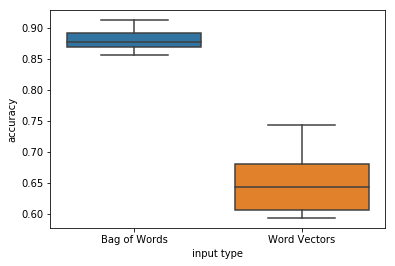

In [13]:
boxplot(x='input type', y='accuracy', data=rnn_scores_data_frame)
plt.show()

# Comparison of all models:

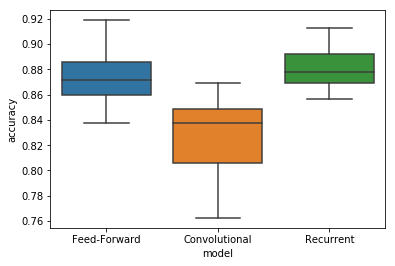

In [17]:
bow_scores = []
for score in ff_bow_scores['accuracies']:
  bow_scores.append(("Feed-Forward", score))
for score in conv_bow_scores['accuracies']:
  bow_scores.append(("Convolutional", score))
for score in rnn_bow_scores['accuracies']:
  bow_scores.append(("Recurrent", score))
    
boxplot(x='model', y='accuracy', data=DataFrame(bow_scores, columns=["model", "accuracy"]))
plt.show()

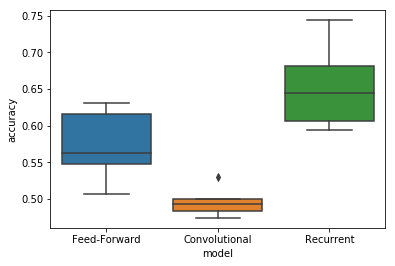

In [18]:
wv_scores = []
for score in ff_wv_scores['accuracies']:
  wv_scores.append(("Feed-Forward", score))
for score in conv_wv_scores['accuracies']:
  wv_scores.append(("Convolutional", score))
for score in rnn_wv_scores['accuracies']:
  wv_scores.append(("Recurrent", score))

boxplot(x='model', y='accuracy', data=DataFrame(wv_scores, columns=["model", "accuracy"]))
plt.show()

From these results we can see that more work is needed to investigate why our embeddings to not perform better than bag of words. There are a number of possibilities, already suggested.